In [517]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report

In [289]:
cases_text_onlyspeaker_df = pd.read_csv("cases_text_onlyspeaker.csv")
cases_text_onlyspeaker_df.head()

,new_name,sentence,sentence_clean,topic_mentioned,sentiment,prob_score_neg,prob_score_neutral,prob_score_pos,has_parking,has_econactivity,...,sent_voice_mentioned,sentpol_voice_mentioned,prob_pos_voice_mentioned,prob_neg_voice_mentioned,positive_voice_mentioned,negative_voice_mentioned,num_voice_mentioned,num_sentences,sentence_lower,count_my_name
0,09-12-2017audio_6ZA-2017-210-CU-1A,My name is Jerry Newman.,My name is Jerry Newman.,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,my name is jerry newman.,1
1,09-12-2017audio_6ZA-2017-210-CU-1A,"Thank you, President Chunkham, members of the ...","Thank you, President Chunkham, members of the ...",NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,"thank you, president chunkham, members of the ...",0
2,09-12-2017audio_6ZA-2017-210-CU-1A,The question that is asked and that was asked ...,The question that is asked and that was asked ...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,the question that is asked and that was asked ...,0
3,09-12-2017audio_6ZA-2017-210-CU-1A,And I think Mr. Chang made an adequate descrip...,And I think Mr. Chang made an adequate descrip...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,and i think mr. chang made an adequate descrip...,0
4,09-12-2017audio_6ZA-2017-210-CU-1A,We started thinking through a business plan an...,We started thinking through a business plan an...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,we started thinking through a business plan an...,0


Load Sentence Embedding Model

In [290]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Get Embeddings

In [291]:
def get_embeddings(column):
  parking_rows = cases_text_onlyspeaker_df[cases_text_onlyspeaker_df[column] == 1]
  all_sentences = parking_rows["sentence"].tolist()
  
  return model.encode(all_sentences), all_sentences

Get Optimal k Clusters (Elbow Test)

In [292]:
def elbow_test(embeddings):
  inertias = []
  k_values = range(1, 20)

  for k in k_values:
      clustering_model = KMeans(n_clusters=k, random_state=0)
      clustering_model.fit(embeddings)
      inertias.append(clustering_model.inertia_)

  plt.figure(figsize=(8, 4))
  plt.plot(k_values, inertias, 'bo-')
  plt.xlabel('Number of Clusters (k)')
  plt.ylabel('Inertia (Sum of Squared Distances)')
  plt.title('Elbow Test for Optimal k')
  plt.grid(True)
  plt.show()

K-means Classifier

In [323]:
# def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10):
#   clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
#   clustering_model.fit(embeddings)
#   clusters = clustering_model.labels_

#   return clusters, clustering_model

#voting
def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10):
    n_samples = embeddings.shape[0]
    all_clusters = np.zeros((n_init, n_samples), dtype=int)

    # Run K-means multiple times and collect the cluster labels
    for i in range(n_init):
        clustering_model = KMeans(n_clusters=num_clusters, random_state=seed + i)
        clustering_model.fit(embeddings)
        all_clusters[i] = clustering_model.labels_

    # Perform voting (finding the most common cluster assignment for each observation)
    final_clusters = mode(all_clusters, axis=0)[0].flatten()

    # Fit the final model with the final clusters (optional, you can return the clustering model from the last iteration instead)
    final_clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
    final_clustering_model.fit(embeddings)
    
    return final_clusters, final_clustering_model



# def k_means_classifier(embeddings, num_clusters=8, seed=42, n_init=10):
#     n_samples = embeddings.shape[0]
#     consensus_matrix = np.zeros((n_samples, n_samples))

#     # Run K-means with random initializations and update the consensus matrix
#     for i in range(n_init):
#         # K-Means with a different random seed each time for diverse initialization
#         clustering_model = KMeans(n_clusters=num_clusters, random_state=seed + i)
#         clustering_model.fit(embeddings)
#         clusters = clustering_model.labels_
        
#         # Update the consensus matrix
#         for j in range(n_samples):
#             for k in range(j + 1, n_samples):
#                 if clusters[j] == clusters[k]:
#                     consensus_matrix[j, k] += 1
#                     consensus_matrix[k, j] += 1

#     # Normalizing the consensus matrix
#     consensus_matrix /= n_init
    
#     # Final clustering using the consensus matrix
#     final_clustering_model = KMeans(n_clusters=num_clusters, random_state=seed)
#     weighted_embeddings = np.dot(consensus_matrix, embeddings)
#     final_clustering_model.fit(weighted_embeddings)
#     final_clusters = final_clustering_model.labels_

#     return final_clusters, final_clustering_model


Visualize Clusters

In [294]:
def pca_plot(embeddings, clusters):
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(embeddings)

  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')

  scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=clusters, cmap='rainbow', alpha=0.7)
  ax.view_init(elev=30, azim=120)


  ax.set_title('3D PCA of Sentence Embeddings with K-Means Clustering')
  ax.set_xlabel('PCA Component 1')
  ax.set_ylabel('PCA Component 2')
  ax.set_zlabel('PCA Component 3')

  plt.colorbar(scatter, ax=ax, label='Cluster ID')
  plt.show()

In [295]:
def example_sentences(clustered_sentences, num_clusters, samples):
  for i in range(num_clusters):
      print(f"\nCluster {i}:")
      example_sentences = clustered_sentences[clustered_sentences['Cluster'] == i]['Sentence'].sample(samples)
      for sentence in example_sentences:
          print(f"- {sentence}")

In [296]:
def display_cluster_breakdown(clusters_df, cluster_labels):
  cluster_counts = clusters_df['Cluster'].value_counts().sort_index()
  total_sentences = cluster_counts.sum()

  cluster_data = []
  for cluster_num, count in cluster_counts.items():
      percentage = (count / total_sentences) * 100
      label = cluster_labels[cluster_num]
      cluster_data.append({
          'Cluster': cluster_num,
          'Pct of Sentences': f"{percentage:.2f}%",
          'Manual Guessed Label': label
      })

  cluster_breakdown_df = pd.DataFrame(cluster_data)
  cluster_breakdown_df.set_index('Cluster', inplace=True)

  return cluster_breakdown_df

Topic: Parking

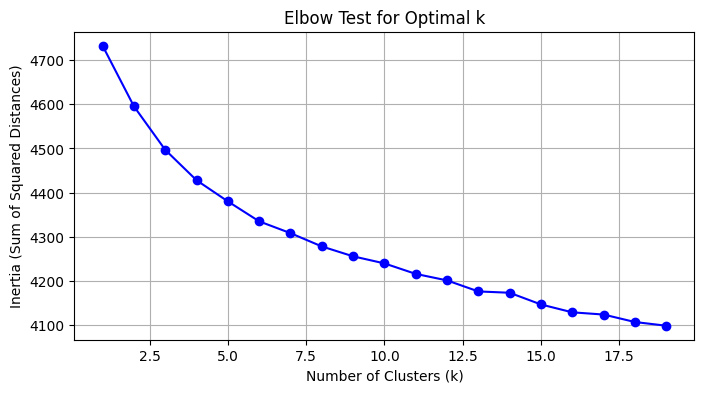

In [297]:
parking_embeddings, parking_sentences = get_embeddings('has_parking')
elbow_test(parking_embeddings)

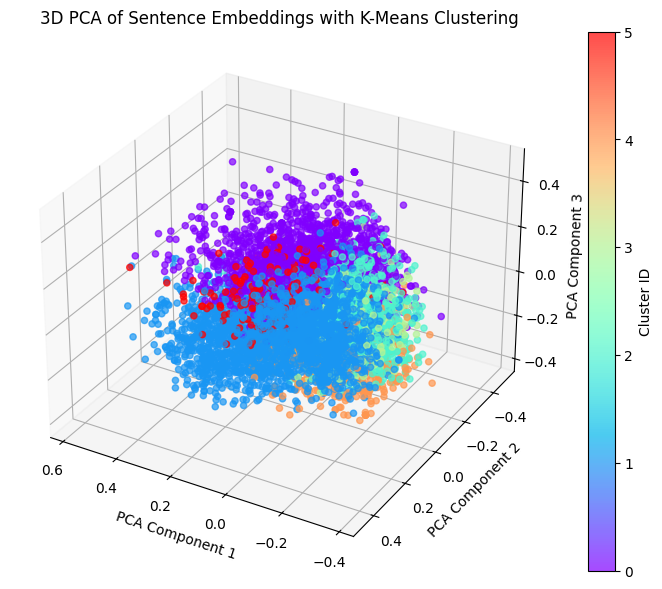

In [508]:
parking_num_clusters = 6
parking_clusters, parking_clustering_model = k_means_classifier(parking_embeddings, num_clusters=parking_num_clusters, seed=42, n_init=30)

parking_clusters_df = pd.DataFrame({'Sentence': parking_sentences, 'Cluster': parking_clusters})
pca_plot(parking_embeddings, parking_clusters)

In [510]:
parking_example_sentences = 4
example_sentences(parking_clusters_df, parking_num_clusters, parking_example_sentences)


Cluster 0:
- Its your effort to mitigate the activity thats spilling over offsite and if you want to say no parking or the parking should have a use the Plocking Purp, that last one I will use with Plocking Purposes.
- The old obviously being the existing parking structure and the new the three story retail and 12 story mixed use building.
- With regard to 0.4, the applicant state that if parking is provided the city cannot invalidate a previous grantand that will be a grant that was issued in 2009 by this body by the West L.A.P.C.
- This project is located in a very much Western specific plant areaspecific plan has specific regulations as it pertains to commercial parking.

Cluster 1:
- And specifically at the front, what the condition that we normally ask for here is that the trees actually be every three stalls set in between the parking.
- And this has to do with the street parking.
- Due to the column grid spacing, theres very deep spaces that provides an opportunity for tandem p

In [505]:
parking_cluster_labels = {
    0: "parking relative to proposed project",
    1: "",
    2: "zoning, planning, beauracracy",
    3: "",
    4: "lack of parking",
    5: ""
}



parking_cluster_breakdown_df = display_cluster_breakdown(parking_clusters_df, parking_cluster_labels)
parking_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,37.88%,parking relative to proposed project
1,23.45%,
2,17.39%,"zoning, planning, beauracracy"
3,1.65%,
4,17.05%,lack of parking
5,2.56%,


Topic: Nuisance

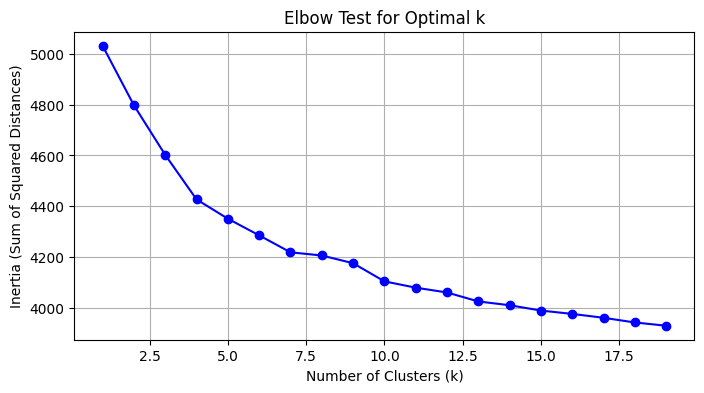

In [326]:
nuisance_embeddings, nuisance_sentences = get_embeddings('has_nuisance')
elbow_test(nuisance_embeddings)

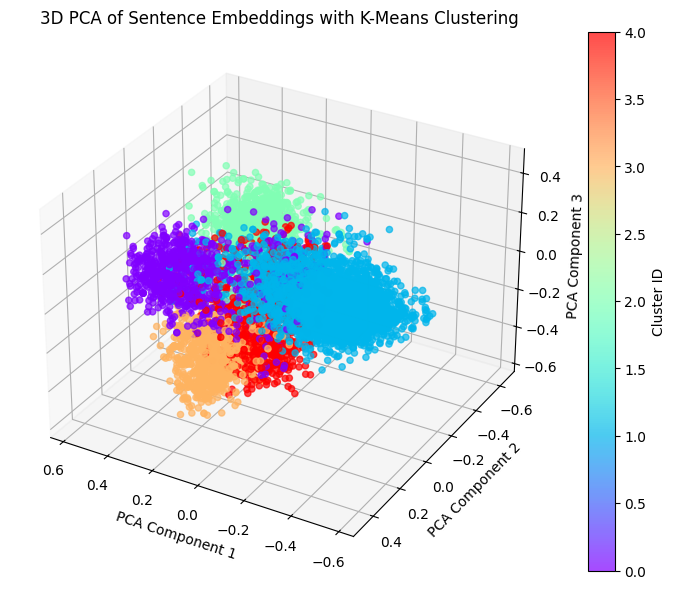

In [428]:
nuisance_num_clusters = 5
nuisance_clusters, nuisance_clustering_model = k_means_classifier(nuisance_embeddings, num_clusters=nuisance_num_clusters, seed=42, n_init=30)
nuisance_clusters_df = pd.DataFrame({'Sentence': nuisance_sentences, 'Cluster': nuisance_clusters})
pca_plot(nuisance_embeddings, nuisance_clusters)

In [412]:
nuisance_example_sentences = 4
example_sentences(nuisance_clusters_df, nuisance_num_clusters, nuisance_example_sentences)


Cluster 0:
- I think you lose completely the privacy, especially these three houses.
- This is Henry to zoning administrator from the testimony given at the public hearing the Department of Transportation did not recommend a driveway on Dissoto that would add additional traffictraffic on to DeSoto.
- It will change the character of of the North Village and have an effect on the charming buildings that surround our buildings that were originally two story buildings and itll totally make congestion with high density buildings such as the proposed building that were talking about.
- So it appears that most of the people who are in the everybody, its just the appearance of the parking lot, the security, the safety.

Cluster 1:
- They are on our wholeholistic view of our neighborhood and the hundred plus households that have to put up with this traffic.
- I guess my question with more of a traffic concern but thank you very much.
- This would just be a big impact on the cell and on the nei

In [413]:
nuisance_cluster_labels = {
    0: "importance and management of open spaces",
    1: "community concerns about development impacts",
    2: "noise, privacy",
    3: "security, crime",
    4: "traffic, local infrastructure"
}


nuisance_cluster_breakdown_df = display_cluster_breakdown(nuisance_clusters_df, nuisance_cluster_labels)
nuisance_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,4.96%,importance and management of open spaces
1,38.64%,community concerns about development impacts
2,17.87%,"noise, privacy"
3,30.17%,"security, crime"
4,8.36%,"traffic, local infrastructure"


Topic: Affordable Housing

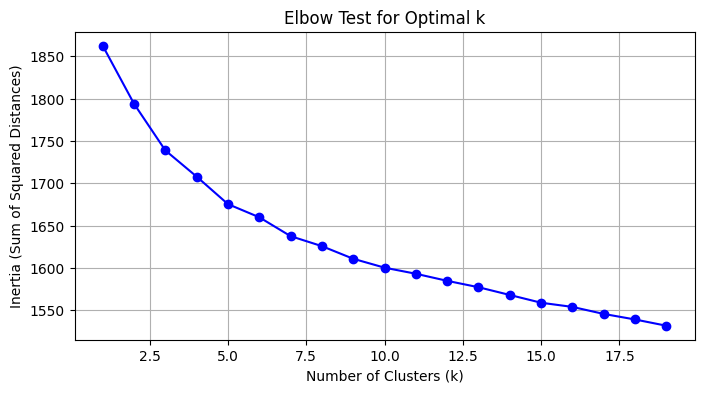

In [414]:
affordable_housing_embeddings, affordable_housing_sentences = get_embeddings('has_affordablehousing')
elbow_test(affordable_housing_embeddings)

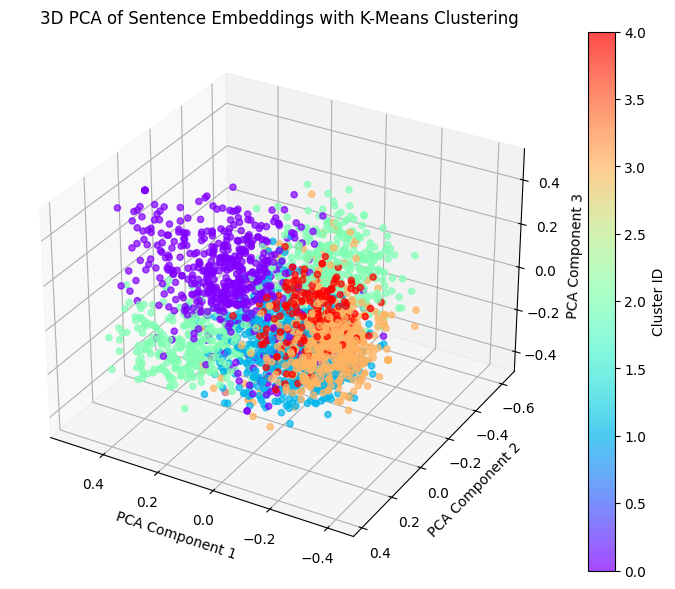

In [429]:
affordable_housing_num_clusters = 5
affordable_housing_clusters, affordable_housing_clustering_model = k_means_classifier(affordable_housing_embeddings, num_clusters=affordable_housing_num_clusters, seed=42, n_init=30)
affordable_housing_clusters_df = pd.DataFrame({'Sentence': affordable_housing_sentences, 'Cluster': affordable_housing_clusters})
pca_plot(affordable_housing_embeddings, affordable_housing_clusters)

In [416]:
affordable_housing_example_sentences = 4
example_sentences(affordable_housing_clusters_df, affordable_housing_num_clusters, affordable_housing_example_sentences)


Cluster 0:
- And with if we were to, if this was to be treated as a density bonus case, lets say they agreed to do the very low income 10 could they have the FAR that theyre seeking?
- While we all support jobs and we also support the economy increasing, we also need to support and ensure that that Los Angeles continues to be a great city and it cant be if its unaffordable.
- I mean, how I wish that there was a big fundwhere we could develop a low income development on the site or other sites, but thats not where we are today.
- We see an impact on the development of the West Angeles Community Development Development and the development of the West Angeles Community Development and the development of the West Angeles Community Development and the development of the West Angeles Community Development and the development of the West Angeles Community Development and the development of the West increase of the number of seniors of West Angeles Church and of the Christian community who ar

In [417]:
affordable_housing_cluster_labels = {
    0: "challenges of providing affordable housing",
    1: " ",
    2: "impact of development on community",
    3: "rent, tenant issues",
    4: "cost, affordability"
}


affordable_housing_cluster_breakdown_df = display_cluster_breakdown(affordable_housing_clusters_df, affordable_housing_cluster_labels)
affordable_housing_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,5.35%,challenges of providing affordable housing
1,23.07%,
2,2.28%,impact of development on community
3,28.19%,"rent, tenant issues"
4,41.12%,"cost, affordability"


Topic: Neighborhood Character

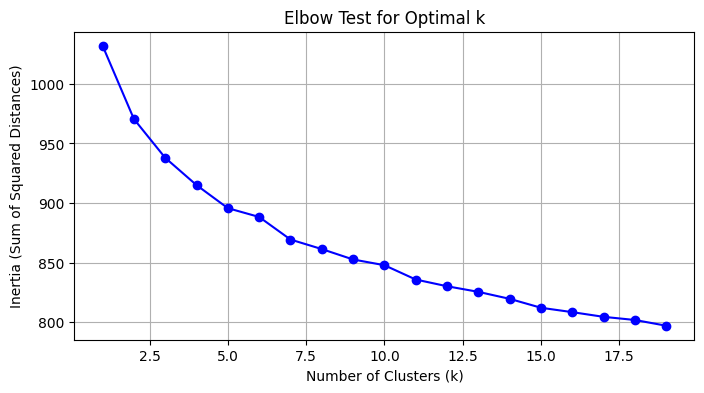

In [418]:
neighborhood_char_embeddings, neighborhood_char_sentences = get_embeddings('has_nhood_character')
elbow_test(neighborhood_char_embeddings)

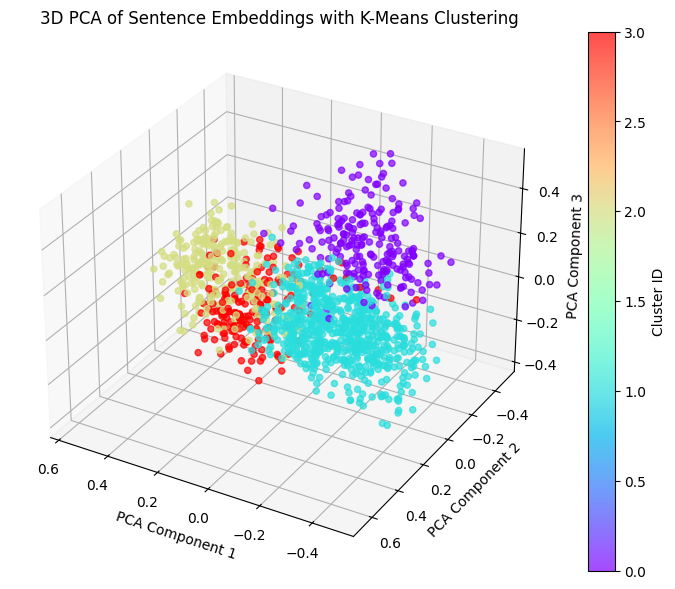

In [430]:
neighborhood_char_num_clusters = 4
neighborhood_char_clusters, neighborhood_char_clustering_model = k_means_classifier(neighborhood_char_embeddings, num_clusters=neighborhood_char_num_clusters, seed=42, n_init=30)
neighborhood_char_clusters_df = pd.DataFrame({'Sentence': neighborhood_char_sentences, 'Cluster': neighborhood_char_clusters})
pca_plot(neighborhood_char_embeddings, neighborhood_char_clusters)

In [420]:
neighborhood_char_example_sentences = 4
example_sentences(neighborhood_char_clusters_df, neighborhood_char_num_clusters, neighborhood_char_example_sentences)


Cluster 0:
- We lose having more displacement.
- The thing is that we know for a fact also in Hollywood, the media studio, media district, the post-production studio, media district, a lot of displacement is occurring as a result of some of the more catalytic commercial retail developments.
- And in that situation for that entitlement, we do look at the at community character.
- The Deputy Advisory Agency used its discretion to opt for the former, as it tends to do councilmember kurets encourages this commission to opt for the preservation of affordability which is equally within your discretion.

Cluster 1:
- So as I started to say before, we just like to take a minute to thank the applicant for working with the community, the neighborhood council, the preservation community, the neighbors.
- Obviously, neighborhood character premise size is very important, obviously in some areas we might have a block thats broken up into 10 stores, maybe there are 5,000 or 2,000 square feet each, m

In [421]:
neighborhood_char_cluster_labels = {
    0: " ",
    1: "historical preservation",
    2: "concern about development impacts on existing properties",
    3: "concern about lack of neighborhood character on residential properties"
}


neighborhood_char_cluster_breakdown_df = display_cluster_breakdown(neighborhood_char_clusters_df, neighborhood_char_cluster_labels)
neighborhood_char_cluster_breakdown_df

,Pct of Sentences,Manual Guessed Label
Cluster,,
0,15.94%,
1,43.60%,historical preservation
2,39.37%,concern about development impacts on existing ...
3,1.09%,concern about lack of neighborhood character o...


accuracy

In [518]:
def get_true_pred_labels(label_file, kmeans_model, other_labels):
  labeled_sentences_df = pd.read_csv(label_file)
  labeled_sentences_ls = labeled_sentences_df["sentence"].tolist()
  true_labels_ls = labeled_sentences_df["label"].tolist()

  labeled_sentences_embedded = model.encode(labeled_sentences_ls)
  pred_labels = kmeans_model.predict(labeled_sentences_embedded)
  pred_labels_ls = pred_labels.tolist()

  pred_labels_ls = [9 if label not in other_labels else label for label in pred_labels_ls]
  
  return true_labels_ls, pred_labels_ls

In [528]:
def get_accuracy_scores(true_labels, pred_labels):
  accuracy = accuracy_score(true_labels, pred_labels)

  report = classification_report(true_labels, pred_labels, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  report_df = report_df.round(2)  # Round to 2 decimal places for better readability

  return accuracy, report_df

In [529]:
parking_other = {0,2,4}
parking_true, parking_pred = get_true_pred_labels("labels/parking_labeled.csv", parking_clustering_model, parking_other)

# accuracy = accuracy_score(parking_true, parking_pred)
# print(f"Accuracy: {accuracy:.2f}")

# report = classification_report(parking_true, parking_pred, output_dict=True)
# report_df = pd.DataFrame(report).transpose()
# report_df = report_df.round(2)  # Round to 2 decimal places for better readability

# report_df
parking_accuracy, parking_report_df = get_accuracy_scores(parking_true, parking_pred)

print(f"Accuracy: {parking_accuracy:.2f}")
parking_report_df

Accuracy: 0.76


,precision,recall,f1-score,support
0,0.44,0.80,0.57,5.00
2,0.88,0.88,0.88,8.00
4,0.78,0.70,0.74,10.00
9,0.83,0.74,0.78,27.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.73,0.78,0.74,50.00
weighted avg,0.79,0.76,0.77,50.00
